In [1]:
import pickle

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv("../data/credit_risk_dataset.csv")

In [4]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [5]:
df = df.convert_dtypes()  # convert df object dtypes to suiting ones  

In [6]:
df.dtypes

person_age                             Int64
person_income                          Int64
person_home_ownership         string[python]
person_emp_length                      Int64
loan_intent                   string[python]
loan_grade                    string[python]
loan_amnt                              Int64
loan_int_rate                        Float64
loan_status                            Int64
loan_percent_income                  Float64
cb_person_default_on_file     string[python]
cb_person_cred_hist_length             Int64
dtype: object

## Handle null

In [7]:
df = df.dropna()

## Handle duplicates

In [8]:
df = df.drop_duplicates()

## Handle Outliers

In [9]:
quartiles = df["person_age"].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]

In [10]:
severe_lower = quartiles[0.25] -3 * iqr
df[df["person_age"] <= severe_lower]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length


In [11]:
severe_upper = quartiles[0.75] +3 * iqr
print(severe_upper)  # 51 years or older is considered a severe outlier!
severe_upper_count = df[df["person_age"] >= severe_upper].count()[0]
print(f"The sever upper outliers represent {(severe_upper_count / df.count()[0])*100}% of the total")

51.0
The sever upper outliers represent 0.8876881512929371% of the total


C:\Users\Admin\AppData\Local\Temp\ipykernel_25684\3721961774.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  severe_upper_count = df[df["person_age"] >= severe_upper].count()[0]
C:\Users\Admin\AppData\Local\Temp\ipykernel_25684\3721961774.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The sever upper outliers represent {(severe_upper_count / df.count()[0])*100}% of the total")


<Axes: ylabel='Frequency'>

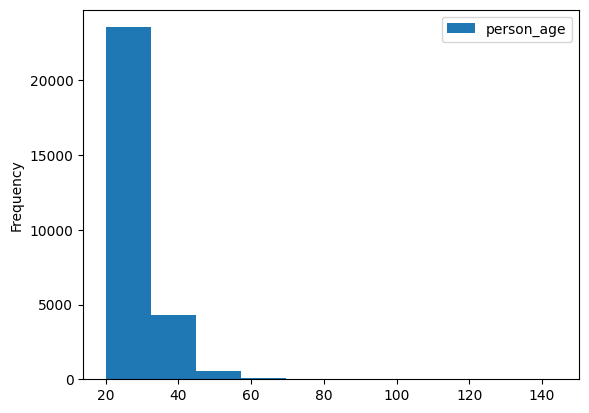

In [12]:
df.plot.hist(y=["person_age"])

## Feature Engineering

In [13]:
encoded_cols = df.select_dtypes(include=["string"]).apply(lambda x: LabelEncoder().fit_transform(x))
encoded_cols.columns = [f"encoded_{col}" for col in encoded_cols.columns]

In [14]:
df = pd.concat([df, encoded_cols], axis=1)

In [15]:
df = df.drop(df.select_dtypes(include=["string"]), axis=1)

In [16]:
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,encoded_person_home_ownership,encoded_loan_intent,encoded_loan_grade,encoded_cb_person_default_on_file
0,22,59000,123,35000,16.02,1,0.59,3,3,4,3,1
1,21,9600,5,1000,11.14,0,0.1,2,2,1,1,0
2,25,9600,1,5500,12.87,1,0.57,3,0,3,2,0
3,23,65500,4,35000,15.23,1,0.53,2,3,3,2,0
4,24,54400,8,35000,14.27,1,0.55,4,3,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1,5800,13.16,0,0.11,30,0,4,2,0
32577,54,120000,4,17625,7.49,0,0.15,19,0,4,0,0
32578,65,76000,3,35000,10.99,1,0.46,28,3,2,1,0
32579,56,150000,5,15000,11.48,0,0.1,26,0,4,1,0


## Use XGBoost

In [17]:
x, y = df.drop(["loan_status"], axis=1), df["loan_status"]
# y should be loan status
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7)

In [18]:
x_train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,encoded_person_home_ownership,encoded_loan_intent,encoded_loan_grade,encoded_cb_person_default_on_file
26657,27,41000,2,2000,15.27,0.05,7,3,0,2,1
27823,28,245000,0,18000,17.39,0.07,9,0,4,4,1
19959,31,50000,3,10500,6.17,0.21,8,3,4,0,0
29353,36,24000,18,6200,10.65,0.26,16,0,5,1,0
27060,27,120000,4,6000,13.79,0.05,10,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...
17768,22,45000,2,8000,16.49,0.18,4,0,1,3,1
23382,30,62000,9,5000,13.11,0.08,8,0,1,2,1
14455,24,30000,1,15000,15.68,0.5,3,2,3,4,0
7280,26,52000,6,6500,6.76,0.13,4,0,4,0,0


In [19]:
df.loc[df['person_emp_length'].isna()]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,encoded_person_home_ownership,encoded_loan_intent,encoded_loan_grade,encoded_cb_person_default_on_file


In [20]:
x_train.iloc[12864]

person_age                              27.0
person_income                        44640.0
person_emp_length                        0.0
loan_amnt                            12800.0
loan_int_rate                          11.83
loan_percent_income                     0.29
cb_person_cred_hist_length               9.0
encoded_person_home_ownership            3.0
encoded_loan_intent                      3.0
encoded_loan_grade                       1.0
encoded_cb_person_default_on_file        0.0
Name: 25973, dtype: Float64

In [21]:
x_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,encoded_person_home_ownership,encoded_loan_intent,encoded_loan_grade,encoded_cb_person_default_on_file
1642,22,57160,2,1500,11.36,0.03,3,3,3,1,0
21143,31,45000,12,6000,9.32,0.13,9,0,4,0,0
30534,41,210000,1,7500,6.03,0.04,14,3,4,0,0
14606,22,45996,6,2000,11.36,0.04,4,3,1,1,0
1176,26,97000,11,16800,12.42,0.17,3,3,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
28793,35,24960,6,1400,8.49,0.06,7,3,5,0,0
4941,25,42996,4,12000,6.17,0.28,4,0,2,0,0
28210,28,110000,3,11000,5.79,0.1,5,0,5,0,0
19249,30,47000,2,13000,9.63,0.28,5,3,0,1,0


In [22]:
xgb = XGBClassifier(enable_categorical=True)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Export model to pickle

In [26]:
with open("../model/xgb_model.pkl", "wb") as file:
    pickle.dump(xgb, file)

In [23]:
important_feats = [
    feat for feat, importance in zip(x_train.columns, xgb.feature_importances_)
    if importance >= 0.02
]
important_feats

['person_age',
 'person_income',
 'person_emp_length',
 'loan_int_rate',
 'loan_percent_income',
 'encoded_person_home_ownership',
 'encoded_loan_intent',
 'encoded_loan_grade']

In [24]:
xgb.score(x_test, y_test)  # accuracy

0.9317038942813706

In [25]:
y_pred = xgb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      6637
         1.0       0.94      0.74      0.83      1914

    accuracy                           0.93      8551
   macro avg       0.94      0.86      0.89      8551
weighted avg       0.93      0.93      0.93      8551

